In [3]:
# Install specific libraries
! pip install transformers
! pip install pycaret

^C


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.0 requires FuzzyTM>=0.4.0, which is not installed.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.


  Obtaining dependency information for pycaret from https://files.pythonhosted.org/packages/3e/6f/b3d59fac3869a7685e68aecdd35c336800bce8c8d3b45687bb82cf9a2848/pycaret-3.3.2-py3-none-any.whl.metadata
  Obtaining dependency information for scikit-learn>1.4.0 from https://files.pythonhosted.org/packages/b2/3b/47b5eaee01ef2b5a80ba3f7f6ecf79587cb458690857d4777bfd77371c6f/scikit_learn-1.7.1-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for pyod>=1.1.3 from https://files.pythonhosted.org/packages/29/38/dee2fc597010654c3a7588f0990192680c5f2d405fbf6f2e5f5c4df1c736/pyod-2.0.5-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/46.3 kB ? eta -:--:--
     ------------------------- ------------ 30.7/46.3 kB 435.7 kB/s eta 0:00:01
     -------------------------------------- 46.3/46.3 kB 461.9 kB/s eta 0:00:00
  Obtaining dependency information for imbalanced-learn>=0.12.0 from https://files.pythonhosted.org/packages/65/60/103dc71019ec2fa987f42f9dbe8864

In [2]:
import numpy as np
import pandas as pd
# import pycaret
import transformers
from transformers import AutoModel, BertTokenizerFast
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
import torch.nn as nn


None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


ModuleNotFoundError: No module named 'torch'

In [4]:
# Load Dataset
true_data = pd.read_csv('cleaned_true.csv')
fake_data = pd.read_csv('cleaned_false.csv')

# Generate labels True/Fake under new Target Column in 'true_data' and 'fake_data'
true_data['Target'] = ['True']*len(true_data)
fake_data['Target'] = ['Fake']*len(fake_data)

# Merge 'true_data' and 'fake_data', by random mixing into a single df called 'data'
data = pd.concat([true_data, fake_data]).sample(frac=1).reset_index(drop=True)

# See how the data looks like
print(data.shape)
data.head()

(38193, 3)


,title,text,Target
0,thousands of tunisians protest against trump's...,tunis (reuters) - thousands of tunisians prote...,True
1,briton accused of terrorism offences posted pi...,london (reuters) - a british man posted a pict...,True
2,egypt attack to spur on saudi-backed muslim mi...,riyadh (reuters) - saudi arabia s powerful cro...,True
3,mongolian parliament ousts prime minister in l...,ulaanbaatar (reuters) - mongolia s parliament ...,True
4,trump spokeswoman denies media report that ohi...,(reuters) - a spokeswoman for u.s. republican ...,True


In [5]:
data['label'] = pd.get_dummies(data.Target)['Fake'].astype(int)


In [6]:
data.head()

,title,text,Target,label
0,thousands of tunisians protest against trump's...,tunis (reuters) - thousands of tunisians prote...,True,0
1,briton accused of terrorism offences posted pi...,london (reuters) - a british man posted a pict...,True,0
2,egypt attack to spur on saudi-backed muslim mi...,riyadh (reuters) - saudi arabia s powerful cro...,True,0
3,mongolian parliament ousts prime minister in l...,ulaanbaatar (reuters) - mongolia s parliament ...,True,0
4,trump spokeswoman denies media report that ohi...,(reuters) - a spokeswoman for u.s. republican ...,True,0


([<matplotlib.patches.Wedge at 0x29862d36120>,
 [Text(-1.1879194673134146, 0.1698450446077638, 'Fake'),
  Text(1.187919482161736, -0.1698449407565409, 'True')],
 [Text(-0.6929530225994919, 0.09907627602119554, '45.5%'),
  Text(0.6929530312610127, -0.09907621544131553, '54.5%')])

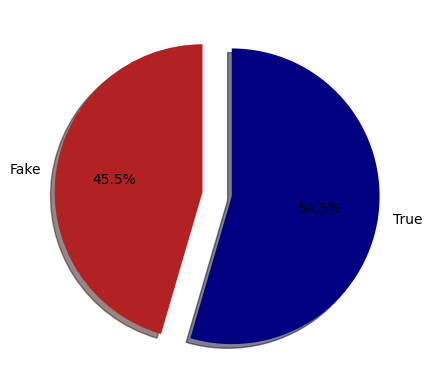

In [7]:
# Checking if our data is well balanced
label_size = [data['label'].sum(),len(data['label'])-data['label'].sum()]
plt.pie(label_size,explode=[0.1,0.1],colors=['firebrick','navy'],startangle=90,shadow=True,labels=['Fake','True'],autopct='%1.1f%%')

In [8]:
pip install ftfy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38193 entries, 0 to 38192
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   38193 non-null  object
 1   text    38193 non-null  object
 2   Target  38193 non-null  object
 3   label   38193 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


In [10]:
import re, ftfy

def clean_for_bert(text):
    if not isinstance(text, str):
        return ""
    text = ftfy.fix_text(text)  # fix encoding issues
    text = re.sub(r"<.*?>", " ", text)  # remove HTML tags
    text = re.sub(r"http\S+|www\S+", "<URL>", text)  # replace URLs
    text = re.sub(r"\s+", " ", text).strip()  # collapse whitespace
    return text

data['bert_text'] = data.apply(
    lambda r: f"{r['title']} [SEP] {clean_for_bert(r['text'])}", axis=1
)

In [11]:
data.head()

,title,text,Target,label,bert_text
0,thousands of tunisians protest against trump's...,tunis (reuters) - thousands of tunisians prote...,True,0,thousands of tunisians protest against trump's...
1,briton accused of terrorism offences posted pi...,london (reuters) - a british man posted a pict...,True,0,briton accused of terrorism offences posted pi...
2,egypt attack to spur on saudi-backed muslim mi...,riyadh (reuters) - saudi arabia s powerful cro...,True,0,egypt attack to spur on saudi-backed muslim mi...
3,mongolian parliament ousts prime minister in l...,ulaanbaatar (reuters) - mongolia s parliament ...,True,0,mongolian parliament ousts prime minister in l...
4,trump spokeswoman denies media report that ohi...,(reuters) - a spokeswoman for u.s. republican ...,True,0,trump spokeswoman denies media report that ohi...


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38193 entries, 0 to 38192
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      38193 non-null  object
 1   text       38193 non-null  object
 2   Target     38193 non-null  object
 3   label      38193 non-null  int64 
 4   bert_text  38193 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.5+ MB


In [13]:
df = data.copy()


In [14]:
from sklearn.model_selection import train_test_split

# Train-Validation-Test split into 70:15:15 ratio

# Train-Temp split (70% train, 30% temp)
train_text, temp_text, train_labels, temp_labels = train_test_split(
    df['bert_text'],
    df['label'],
    random_state=2018,
    test_size=0.3,
    stratify=df['Target']   # stratify on label for balanced split
)

# Validation-Test split (15% each)
val_text, test_text, val_labels, test_labels = train_test_split(
    temp_text,
    temp_labels,
    random_state=2018,
    test_size=0.5,
    stratify=temp_labels   # stratify again to maintain class balance
)

In [22]:
# Load BERT model and tokenizer via HuggingFace Transformers
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


Text(0, 0.5, 'Number of texts')

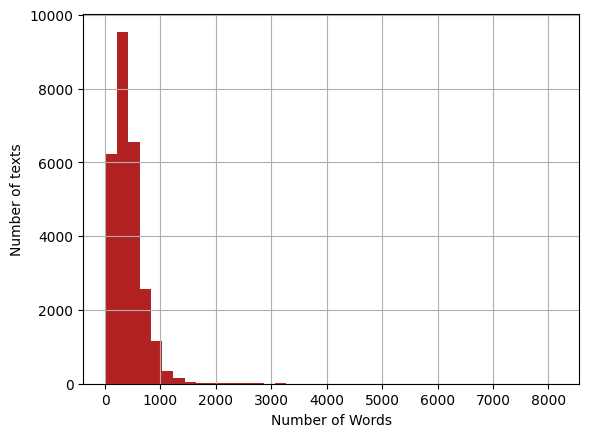

In [16]:
# Plot histogram of the number of words in train data 'title'
seq_len = [len(title.split()) for title in train_text]

pd.Series(seq_len).hist(bins = 40,color='firebrick')
plt.xlabel('Number of Words')
plt.ylabel('Number of texts')

In [23]:
lengths = df['bert_text'].apply(lambda x: len(tokenizer.encode(x, add_special_tokens=True)))
print(lengths.describe(percentiles=[.5, .75, .9, .95, .99]))


Token indices sequence length is longer than the specified maximum sequence length for this model (622 > 512). Running this sequence through the model will result in indexing errors


KeyboardInterrupt: 

In [24]:
df.head()

,title,text,Target,label,bert_text
0,thousands of tunisians protest against trump's...,tunis (reuters) - thousands of tunisians prote...,True,0,thousands of tunisians protest against trump's...
1,briton accused of terrorism offences posted pi...,london (reuters) - a british man posted a pict...,True,0,briton accused of terrorism offences posted pi...
2,egypt attack to spur on saudi-backed muslim mi...,riyadh (reuters) - saudi arabia s powerful cro...,True,0,egypt attack to spur on saudi-backed muslim mi...
3,mongolian parliament ousts prime minister in l...,ulaanbaatar (reuters) - mongolia s parliament ...,True,0,mongolian parliament ousts prime minister in l...
4,trump spokeswoman denies media report that ohi...,(reuters) - a spokeswoman for u.s. republican ...,True,0,trump spokeswoman denies media report that ohi...


In [25]:
from transformers import BertTokenizer

# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Set max sequence length
MAX_LENGTH = 512  # BERT’s maximum input length

# Tokenize and encode sequences in the train set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length=MAX_LENGTH,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)

# Tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length=MAX_LENGTH,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)

# Tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length=MAX_LENGTH,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)

In [19]:
# Convert tokenized outputs to tensors directly
train_seq = tokens_train['input_ids']
train_mask = tokens_train['attention_mask']
train_y = torch.tensor(train_labels.tolist())

val_seq = tokens_val['input_ids']
val_mask = tokens_val['attention_mask']
val_y = torch.tensor(val_labels.tolist())

test_seq = tokens_test['input_ids']
test_mask = tokens_test['attention_mask']
test_y = torch.tensor(test_labels.tolist())

In [20]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Define batch size (you can tune this based on GPU memory)
batch_size = 32

# Train DataLoader
train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Validation DataLoader
val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Test DataLoader
test_data = TensorDataset(test_seq, test_mask, test_y)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [26]:
# Freezing the parameters and defining trainable BERT structure
for param in bert.parameters():
    param.requires_grad = False    # false here means gradient need not be computed

In [27]:
import torch
import torch.nn as nn
from torch.optim import AdamW
from transformers import BertModel

# ---------------------------
# BERT Architecture
# ---------------------------
class BERT_Arch(nn.Module):
    def __init__(self):   # <-- FIXED: double underscores
        super(BERT_Arch, self).__init__()

        # Load BERT backbone
        self.bert = BertModel.from_pretrained("bert-base-uncased")

        # Freeze BERT parameters
        for param in self.bert.parameters():
            param.requires_grad = False

        # Classifier layers
        self.classifier = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 2),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, sent_id, mask):
        # Forward pass through BERT
        outputs = self.bert(sent_id, attention_mask=mask)
        cls_hs = outputs.pooler_output   # [CLS] pooled output

        # Forward pass through classifier
        x = self.classifier(cls_hs)
        return x


# ---------------------------
# Initialize Model
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERT_Arch().to(device)

# ---------------------------
# Optimizer & Loss
# ---------------------------
print(f"Number of trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = nn.NLLLoss()

print("✅ Model initialized successfully!")
print(f"📌 Using device: {device}")


Number of trainable parameters: 394754
✅ Model initialized successfully!
📌 Using device: cuda


In [28]:
# Define Loss Function
cross_entropy = nn.CrossEntropyLoss()

# ---------------------------
# Training Function
# ---------------------------
def train():
    model.train()
    total_loss = 0

    for step, batch in enumerate(train_dataloader):
        if step % 50 == 0 and not step == 0:  # Progress update
            print(f'  Batch {step:>5,}  of  {len(train_dataloader):>5,}.')

        # Move batch to device
        sent_id, mask, labels = [r.to(device) for r in batch]

        # Reset gradients
        model.zero_grad()

        # Forward pass
        preds = model(sent_id, mask)

        # Compute loss
        loss = cross_entropy(preds, labels)
        total_loss += loss.item()

        # Backward pass
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters
        optimizer.step()

    # Compute average training loss
    avg_loss = total_loss / len(train_dataloader)
    return avg_loss


# ---------------------------
# Evaluation Function
# ---------------------------
def evaluate():
    print("\nEvaluating...")
    model.eval()
    total_loss = 0

    for step, batch in enumerate(val_dataloader):
        if step % 50 == 0 and not step == 0:
            print(f'  Batch {step:>5,}  of  {len(val_dataloader):>5,}.')

        # Move batch to device
        sent_id, mask, labels = [t.to(device) for t in batch]

        with torch.no_grad():  # No gradient calculation
            preds = model(sent_id, mask)
            loss = cross_entropy(preds, labels)
            total_loss += loss.item()

    # Compute average validation loss
    avg_loss = total_loss / len(val_dataloader)
    return avg_loss

In [ ]:
# Train and predict
best_valid_loss = float('inf')
train_losses=[]                   # empty lists to store training and validation loss of each epoch
valid_losses=[]
epochs=3
for epoch in range(epochs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    train_loss = train()                       # train model
    valid_loss = evaluate()                    # evaluate model
    if valid_loss < best_valid_loss:              # save the best model
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'c2_new_model_weights.pt')
    train_losses.append(train_loss)               # append training and validation loss
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 3
  Batch    50  of    836.
  Batch   100  of    836.
  Batch   150  of    836.
  Batch   200  of    836.
  Batch   250  of    836.
  Batch   300  of    836.
  Batch   350  of    836.
  Batch   400  of    836.
  Batch   450  of    836.
  Batch   500  of    836.
  Batch   550  of    836.
  Batch   600  of    836.
  Batch   650  of    836.
  Batch   700  of    836.
  Batch   750  of    836.
  Batch   800  of    836.

Evaluating...
  Batch    50  of    180.
  Batch   100  of    180.
  Batch   150  of    180.

Training Loss: 0.436
Validation Loss: 0.264

 Epoch 2 / 3
  Batch    50  of    836.
  Batch   100  of    836.
  Batch   150  of    836.
  Batch   200  of    836.
  Batch   250  of    836.
  Batch   300  of    836.
  Batch   350  of    836.
  Batch   400  of    836.
  Batch   450  of    836.
  Batch   500  of    836.
  Batch   550  of    836.
  Batch   600  of    836.
  Batch   650  of    836.
  Batch   700  of    836.
  Batch   750  of    836.
  Batch   800  of    836.

E

In [29]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.metrics import classification_report

# Load model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

path = 'c2_new_model_weights (1).pt'
model.load_state_dict(torch.load(path, map_location=device))
model.to(device)   # move model to GPU
model.eval()

# Create dataset & dataloader for batching
test_data = TensorDataset(test_seq, test_mask, test_y)
test_loader = DataLoader(test_data, batch_size=16)

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        b_seq, b_mask, b_labels = [t.to(device) for t in batch]  # move batch to GPU

        outputs = model(b_seq, b_mask)   # forward pass on GPU
        preds = outputs.detach().cpu().numpy()  # bring predictions back to CPU for numpy

        all_preds.append(preds)
        all_labels.append(b_labels.cpu().numpy())  # bring labels back to CPU

# Concatenate everything
all_preds = np.concatenate(all_preds, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Get predicted classes
final_preds = np.argmax(all_preds, axis=1)

# Print classification report
print(classification_report(all_labels, final_preds))


              precision    recall  f1-score   support

           0       0.93      0.98      0.96      3124
           1       0.97      0.92      0.94      2605

    accuracy                           0.95      5729
   macro avg       0.95      0.95      0.95      5729
weighted avg       0.95      0.95      0.95      5729



In [4]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121


Looking in indexes: https://download.pytorch.org/whl/cu121
     ---------------------------------------- 0.0/2.4 GB ? eta -:--:--
     ---------------------------------------- 0.0/2.4 GB ? eta -:--:--
     ---------------------------------------- 0.0/2.4 GB 653.6 kB/s eta 1:02:28
     ---------------------------------------- 0.0/2.4 GB 744.7 kB/s eta 0:54:49
     ---------------------------------------- 0.0/2.4 GB 901.1 kB/s eta 0:45:19
     ---------------------------------------- 0.0/2.4 GB 871.5 kB/s eta 0:46:51
     ---------------------------------------- 0.0/2.4 GB 827.9 kB/s eta 0:49:19
     ---------------------------------------- 0.0/2.4 GB 944.1 kB/s eta 0:43:15
     ---------------------------------------- 0.0/2.4 GB 964.9 kB/s eta 0:42:19
     ---------------------------------------- 0.0/2.4 GB 1.1 MB/s eta 0:38:20
     ---------------------------------------- 0.0/2.4 GB 1.1 MB/s eta 0:37:44
     ---------------------------------------- 0.0/2.4 GB 1.2 MB/s eta 0:35:17
     

ERROR: THESE PACKAGES DO NOT MATCH THE HASHES FROM THE REQUIREMENTS FILE. If you have updated the package versions, please update the hashes. Otherwise, examine the package contents carefully; someone may have tampered with them.
    torch from https://download.pytorch.org/whl/cu121/torch-2.5.1%2Bcu121-cp311-cp311-win_amd64.whl#sha256=4bcee18f00c43c815efad8efaa3bca584ffdc8d2cd35ef4c44c814f2739d9191:
        Expected sha256 4bcee18f00c43c815efad8efaa3bca584ffdc8d2cd35ef4c44c814f2739d9191
             Got        551c2ce086130a163d132d505dbd623bb8fe4b6e17af1ea773eb1f8f6194ca89



In [5]:
import torch
import numpy as np

# Load model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

path = "c2_new_model_weights (1).pt"
model.load_state_dict(torch.load(path, map_location=device))
model.to(device)   # move model to GPU

# Example unseen news
unseen_news_text = [
    "Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing",  # Fake
    "WATCH: George W. Bush Calls Out Trump For Supporting White Supremacy",            # Fake
    "U.S. lawmakers question businessman at 2016 Trump Tower meeting: sources",        # True
    "Trump administration issues new rules on U.S. visa waivers"                       # True
]

# Tokenize and encode sequences
MAX_LENGTH = 15
tokens_unseen = tokenizer.batch_encode_plus(
    unseen_news_text,
    max_length=MAX_LENGTH,
    padding="max_length",
    truncation=True,
    return_tensors="pt"
)

unseen_seq = tokens_unseen["input_ids"].to(device)
unseen_mask = tokens_unseen["attention_mask"].to(device)

# Prediction
with torch.no_grad():
    outputs = model(input_ids=unseen_seq, attention_mask=unseen_mask)
    logits = outputs if isinstance(outputs, torch.Tensor) else outputs.logits
    preds = torch.argmax(logits, dim=1).cpu().numpy()

print(preds)


ModuleNotFoundError: No module named 'torch'

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.metrics import classification_report

# Create dataset & dataloader for batching
test_data = TensorDataset(test_seq, test_mask, test_y)
test_loader = DataLoader(test_data, batch_size=16)  # adjust batch_size if needed

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        b_seq, b_mask, b_labels = batch

        # If model is on GPU, move tensors too
        if next(model.parameters()).is_cuda:
            b_seq = b_seq.to("cuda")
            b_mask = b_mask.to("cuda")

        outputs = model(b_seq, b_mask)   # forward pass
        preds = outputs.detach().cpu().numpy()

        all_preds.append(preds)
        all_labels.append(b_labels.numpy())

# Concatenate everything
all_preds = np.concatenate(all_preds, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Get predicted classes
final_preds = np.argmax(all_preds, axis=1)

# Print classification report
print(classification_report(all_labels, final_preds))


KeyboardInterrupt: 